In [1]:
!pip install -q torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

In [4]:
# Example to convert List into tensors
mylist = [1, 2, 3, 4]

tensors = torch.tensor(mylist)
print(tensors)
print(type(tensors))

tensor([1, 2, 3, 4])
<class 'torch.Tensor'>


## Step1: Input Embedding Layer
Lets take following sentence - "he runs fast" and convert their Word Embeddings into Tensors

In [5]:
# Similarly, we will convert the Word Embeddings in the Tensor

he = [0.6, 0.4]
runs = [1.1, 0.4]
fast = [1.4, 0.2]

X = torch.tensor([he, runs, fast]) # 3 Tokens | 2 dims
print(X)
print(type(X))

tensor([[0.6000, 0.4000],
        [1.1000, 0.4000],
        [1.4000, 0.2000]])
<class 'torch.Tensor'>


## Step2: Encoder Block



In [15]:
wt_query = torch.eye(2)
wt_key = torch.eye(2)
wt_value = torch.tensor([[0.1, 0.2],
                     [1.4, 0.2]])

print(wt_query)
print(wt_key)
print(wt_value)

tensor([[1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.]])
tensor([[0.1000, 0.2000],
        [1.4000, 0.2000]])


## Step3: Compute Query, Key & Value Pair

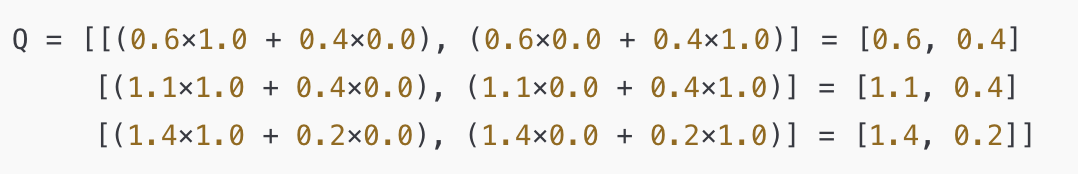

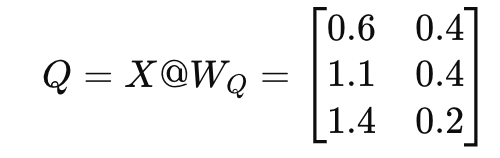

(Which is the same as X, since W_Q is identity here.)

This transformation **projects the input token embeddings** into a **"Query"** space, which will later be used to calculate attention scores.

In BERT:

* Each token is converted into:
  * Query vector Q
  * Key vector K
  * Value vector V

All three come from separate learned weight matrices (W_Q, W_K, W_V).

In [16]:
# Matrix Multiplication: Multiply the input embeddings X with the weight matrix W_Q to produce Query vectors Q.
query = X@wt_query # → (3x2) × (2x2) = (3x2)
key = X@wt_key
value = X@wt_value

## 🔹 Step 4: Scaled Dot-Product Attention

Now compute **attention scores** using:
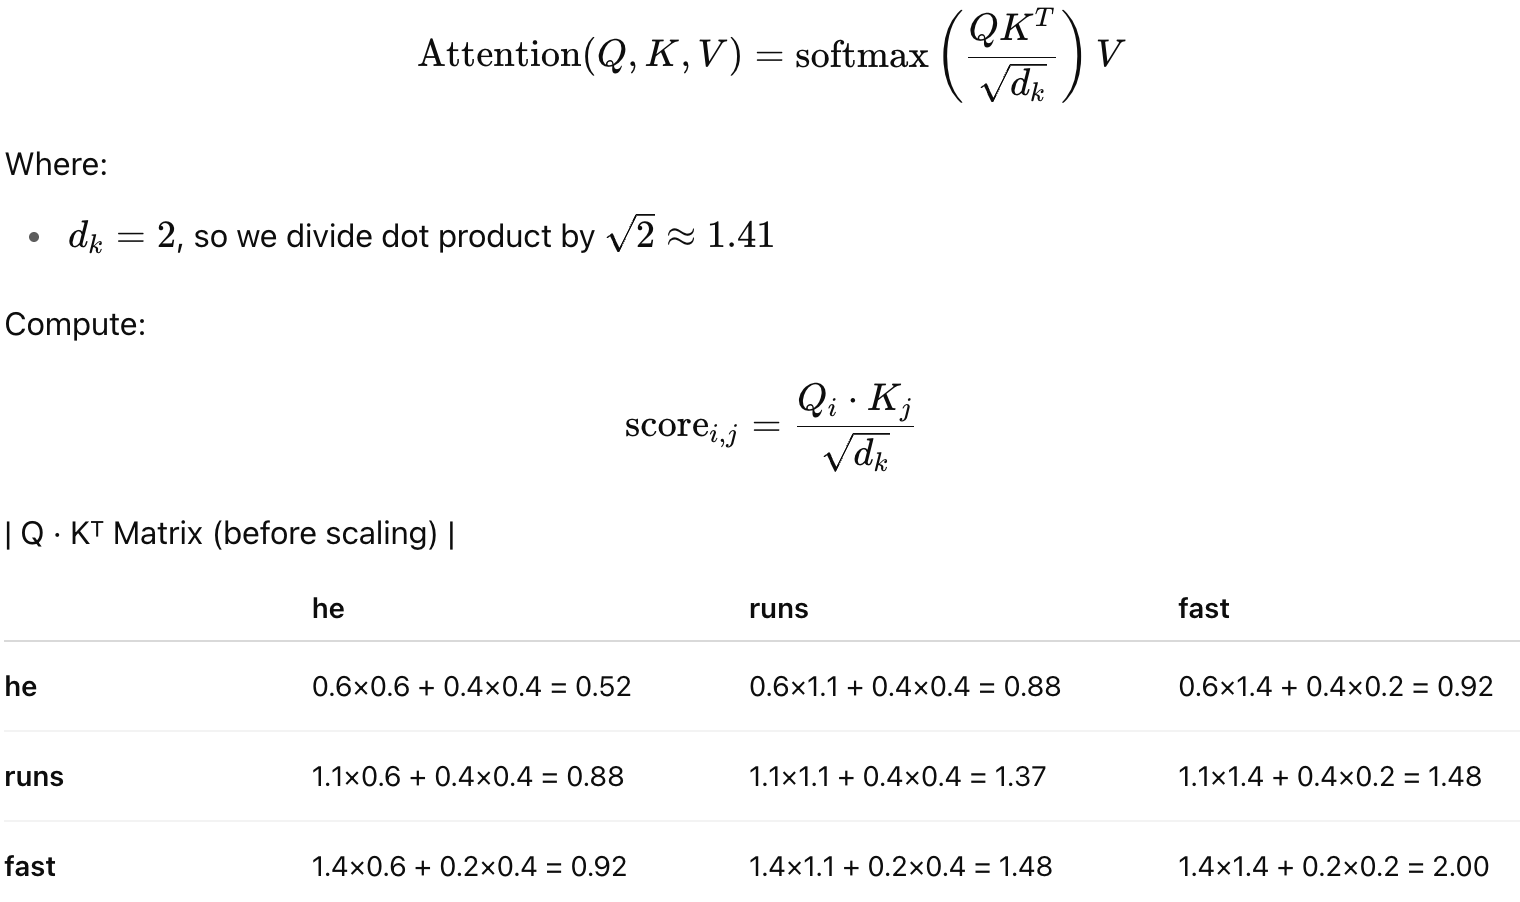

Now we scale:

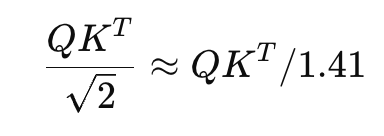

## Apply Softmax on Scores
* Now apply softmax to each row of the scaled score matrix to get attention weights.
* Each row sums to 1, and tells how much to attend to each other token.

* Example softmax row (for “he”):-
  * **softmax([0.37, 0.62, 0.65]) ≈ [0.28, 0.35, 0.37]**

## Multiply Weights × Vectors

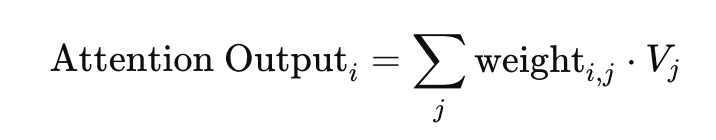

In [18]:
# Compute scaled dot-product attention
d_k = query.size(-1)
scores = query@key.T/np.sqrt(d_k)
attn_weights = F.softmax(scores, dim=-1)
attn_output = attn_weights@value

print(attn_weights)
print(attn_output)

tensor([[0.2806, 0.3470, 0.3724],
        [0.2361, 0.3483, 0.4156],
        [0.2089, 0.3427, 0.4484]])
tensor([[0.5629, 0.2794],
        [0.5543, 0.2847],
        [0.5475, 0.2881]])


## Step5: Feedforward Network Layer

Each token’s attention output goes through a small MLP

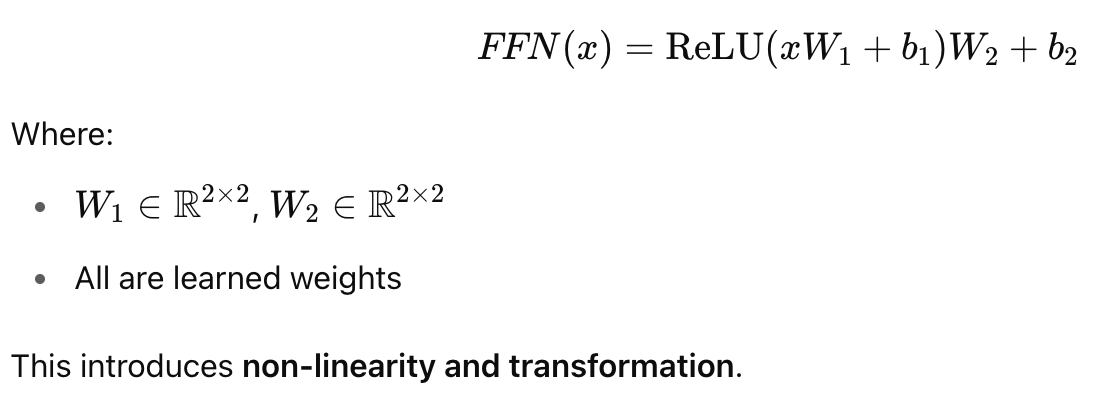

In [25]:
# Feedforward Network
W1 = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
b1 = torch.tensor([0.0, 0.0])
W2 = torch.tensor([[0.5, -1.0], [1.0, 0.5]])
b2 = torch.tensor([0.1, -0.2])

ffn_output = F.relu(attn_output @ W1 + b1) @ W2 + b2

## Add & LayerNorm

            **LayerNorm(x+Sublayer(x))**

Here:
* Add input and output (residual connection)
* Normalize to stabilize gradients

In [26]:
# Step 4: Add & LayerNorm
final_output = F.layer_norm(attn_output + ffn_output, ffn_output.shape[1:])
print(final_output)

tensor([[ 1.0000, -1.0000],
        [ 1.0000, -1.0000],
        [ 1.0000, -1.0000]])


# ✅ Final Output:

Now we get:

* A new vector for each token
* Each vector knows about the context of all other tokens

That’s what makes **BERT bidirectional** and powerful

In [23]:
# View results
df_input = pd.DataFrame(X.numpy(), columns=["dim1", "dim2"])
df_attn = pd.DataFrame(attn_output.numpy(), columns=["A1", "A2"])
df_ffn = pd.DataFrame(ffn_output.numpy(), columns=["F1", "F2"])
df_final = pd.DataFrame(final_output.numpy(), columns=["Final1", "Final2"])

In [24]:
print("Input Embeddings:")
display(df_input)
print("Attention Output:")
display(df_attn)
print("FFN Output:")
display(df_ffn)
print("Final Output after Residual + LayerNorm:")
display(df_final)

Input Embeddings:


,dim1,dim2
0,0.6,0.4
1,1.1,0.4
2,1.4,0.2


Attention Output:


,A1,A2
0,0.562871,0.279383
1,0.554287,0.284706
2,0.547463,0.288076


FFN Output:


,F1,F2
0,3.043784,-0.479383
1,3.051599,-0.484706
2,3.053073,-0.488076


Final Output after Residual + LayerNorm:


,Final1,Final2
0,0.999999,-0.999999
1,0.999999,-0.999999
2,0.999999,-0.999999
